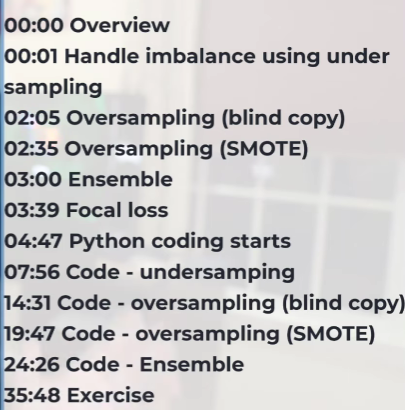


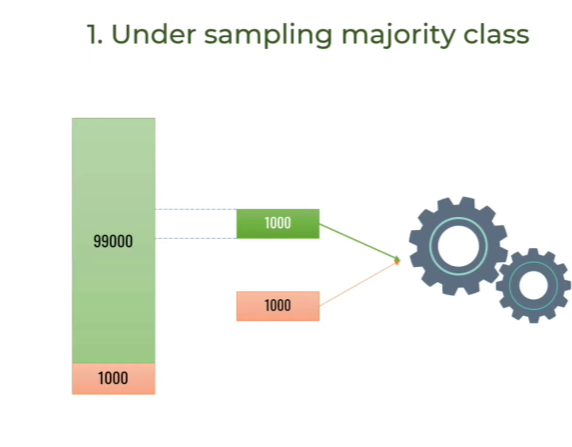


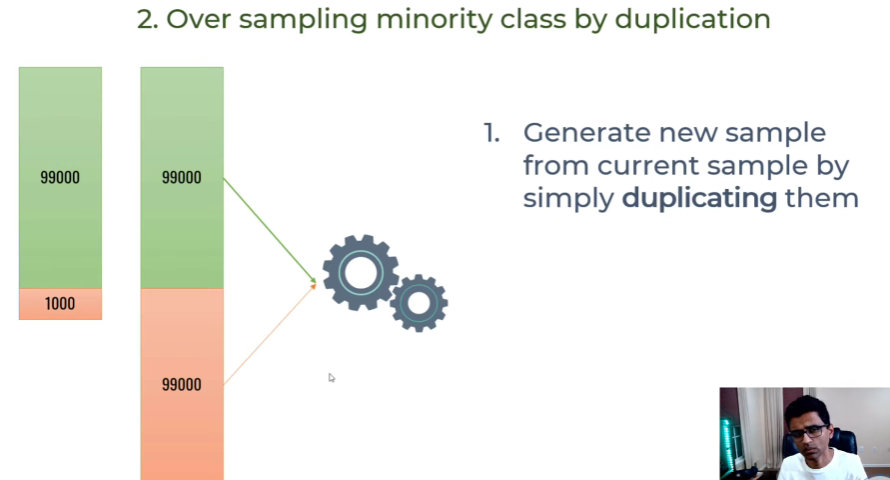


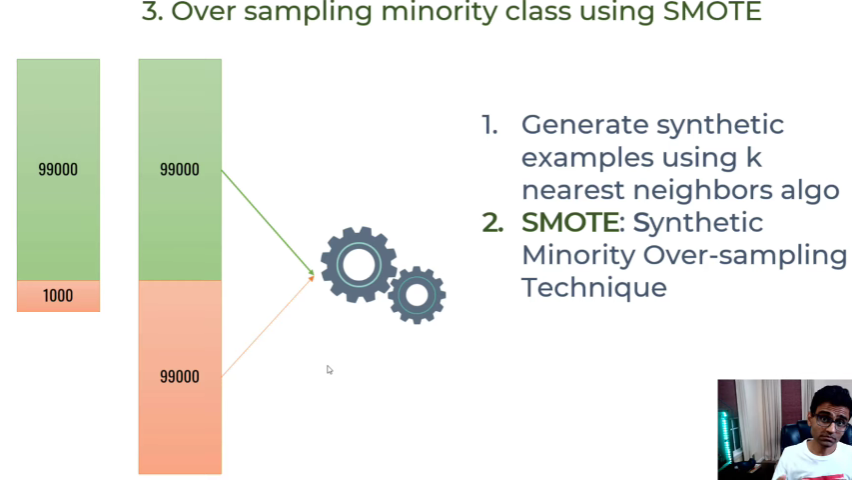


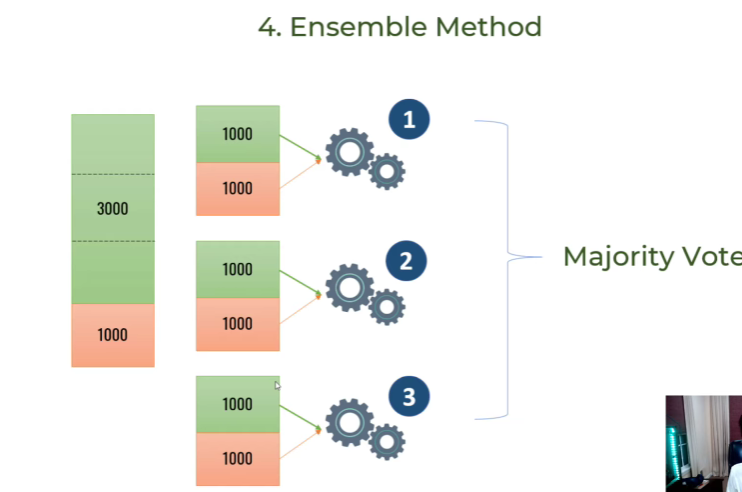


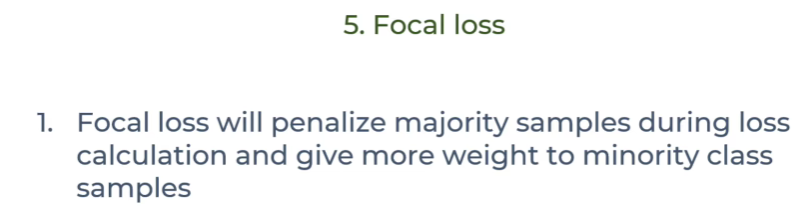

https://medium.com/analytics-vidhya/how-focal-loss-fixes-the-class-imbalance-problem-in-object-detection-3d2e1c4da8d7#:~:text=Focal%20loss%20is%20very%20useful,is%20simple%20and%20highly%20effective


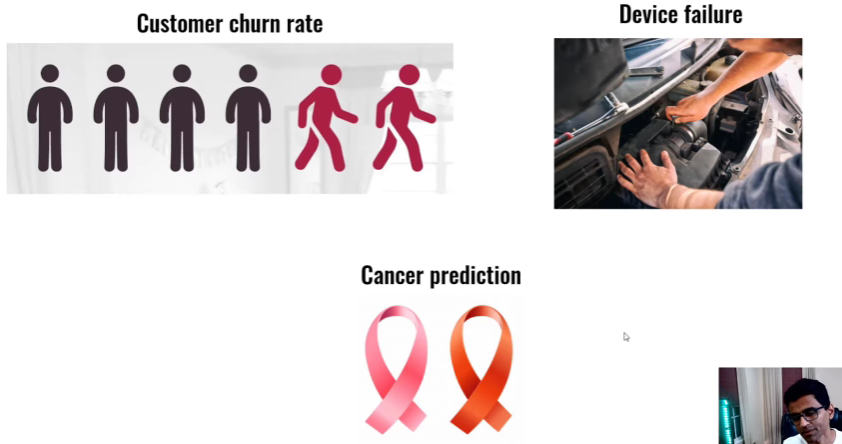


## Handling imbalanced data in customer churn prediction

Customer churn prediction is to measure why customers are leaving a business. In this tutorial we will be looking at customer churn in telecom business. We will build a deep learning model to predict the churn and use precision,recall, f1-score to measure performance of our model. We will then handle imbalance in data using various techniques and improve f1-score


In [3]:

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [4]:

import warnings
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("customer_chrn.csv")
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3755,8443-ZRDBZ,Male,0,No,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,76.05,318.9,Yes
6953,1564-NTYXF,Female,1,No,No,13,Yes,Yes,Fiber optic,No,...,No,No,No,Yes,Month-to-month,Yes,Electronic check,82.00,1127.2,Yes
2142,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8,No
2324,2774-LVQUS,Female,1,Yes,No,15,Yes,Yes,Fiber optic,No,...,Yes,Yes,No,No,Month-to-month,Yes,Electronic check,83.05,1258.3,Yes
6735,6365-HITVU,Female,0,Yes,Yes,71,Yes,No,DSL,Yes,...,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),87.25,6328.7,No


In [6]:
df.Churn.value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [7]:
517400/df.shape[0]  # 73% No

73.46301292063042

In [8]:
1869/df.shape[0]  # 26% Yes

0.2653698707936959

**First of all, drop customerID column as it is of no use**


In [9]:
df.drop('customerID', axis='columns', inplace=True)

In [10]:
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

**Quick glance at above makes me realize that TotalCharges should be float but it is an object. Let's check what's going on with this column**


In [11]:
df.TotalCharges.values

array(['29.85', '1889.5', '108.15', ..., '346.45', '306.6', '6844.5'],
      dtype=object)

**Ahh... it is string. Lets convert it to numbers**


In [12]:
pd.to_numeric(df.TotalCharges, errors='coerce').isnull()

0       False
1       False
2       False
3       False
4       False
        ...  
7038    False
7039    False
7040    False
7041    False
7042    False
Name: TotalCharges, Length: 7043, dtype: bool

In [13]:
df[pd.to_numeric(df.TotalCharges, errors='coerce').isnull()]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


In [14]:
df.iloc[488].TotalCharges

' '

In [15]:

df[df.TotalCharges != ' '].shape

(7032, 20)

In [16]:

df1 = df[df.TotalCharges != ' ']
df1.shape

(7032, 20)

In [17]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [18]:
df1.TotalCharges = pd.to_numeric(df1.TotalCharges)

In [19]:
df1.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

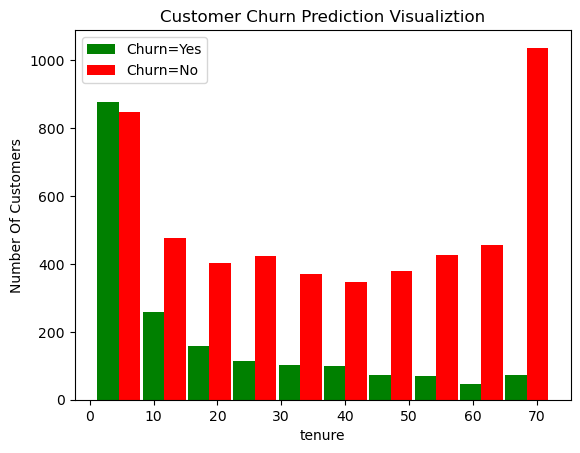

In [20]:
tenure_churn_no = df1[df1.Churn == 'No'].tenure
tenure_churn_yes = df1[df1.Churn == 'Yes'].tenure


plt.xlabel("tenure")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([tenure_churn_yes, tenure_churn_no], rwidth=0.95, color=['green', 'red'], label=['Churn=Yes', 'Churn=No'])
plt.legend()

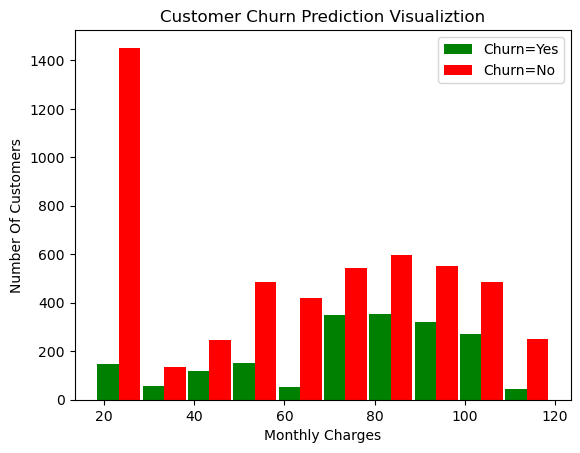

In [21]:
mc_churn_no = df1[df1.Churn == 'No'].MonthlyCharges
mc_churn_yes = df1[df1.Churn == 'Yes'].MonthlyCharges

plt.xlabel("Monthly Charges")
plt.ylabel("Number Of Customers")
plt.title("Customer Churn Prediction Visualiztion")

blood_sugar_men = [113, 85, 90, 150, 149, 88, 93, 115, 135, 80, 77, 82, 129]
blood_sugar_women = [67, 98, 89, 120, 133, 150, 84, 69, 89, 79, 120, 112, 100]

plt.hist([mc_churn_yes, mc_churn_no], rwidth=0.95, color=['green', 'red'], label=['Churn=Yes', 'Churn=No'])
plt.legend()

**Many of the columns are yes, no etc. Let's print unique values in object columns to see data values**


In [22]:
def print_unique_col_values(df):
    for column in df:
        if df[column].dtypes == 'object':
            print(f'{column}: {df[column].unique()}')

In [23]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No phone service' 'No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes' 'No internet service']
OnlineBackup: ['Yes' 'No' 'No internet service']
DeviceProtection: ['No' 'Yes' 'No internet service']
TechSupport: ['No' 'Yes' 'No internet service']
StreamingTV: ['No' 'Yes' 'No internet service']
StreamingMovies: ['No' 'Yes' 'No internet service']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Some of the columns have no internet service or no phone service, that can be replaced with a simple No**


In [24]:
df1.replace('No internet service', 'No', inplace=True)
df1.replace('No phone service', 'No', inplace=True)

In [25]:
print_unique_col_values(df1)

gender: ['Female' 'Male']
Partner: ['Yes' 'No']
Dependents: ['No' 'Yes']
PhoneService: ['No' 'Yes']
MultipleLines: ['No' 'Yes']
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: ['No' 'Yes']
OnlineBackup: ['Yes' 'No']
DeviceProtection: ['No' 'Yes']
TechSupport: ['No' 'Yes']
StreamingTV: ['No' 'Yes']
StreamingMovies: ['No' 'Yes']
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: ['Yes' 'No']
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn: ['No' 'Yes']


**Convert Yes and No to True or False**


In [26]:
yes_no_columns = ['Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
                  'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 'Churn']
for col in yes_no_columns:
    df1[col].replace({'Yes': True, 'No': False}, inplace=True)

In [27]:
df1['SeniorCitizen'].replace({1: True, 0: False}, inplace=True)
df1['gender'].replace({'Female': True, 'Male': False}, inplace=True)

In [28]:
for col in df1:
    print(f'{col}: {df1[col].unique()}')

gender: [ True False]
SeniorCitizen: [False  True]
Partner: [ True False]
Dependents: [False  True]
tenure: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]
PhoneService: [False  True]
MultipleLines: [False  True]
InternetService: ['DSL' 'Fiber optic' 'No']
OnlineSecurity: [False  True]
OnlineBackup: [ True False]
DeviceProtection: [False  True]
TechSupport: [False  True]
StreamingTV: [False  True]
StreamingMovies: [False  True]
Contract: ['Month-to-month' 'One year' 'Two year']
PaperlessBilling: [ True False]
PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
MonthlyCharges: [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
TotalCharges: [  29.85 1889.5   108.15 ...  346.45  306.6  6844.5 ]
Churn: [False  True]


In [29]:
df1.dtypes

gender                 bool
SeniorCitizen          bool
Partner                bool
Dependents             bool
tenure                int64
PhoneService           bool
MultipleLines          bool
InternetService      object
OnlineSecurity         bool
OnlineBackup           bool
DeviceProtection       bool
TechSupport            bool
StreamingTV            bool
StreamingMovies        bool
Contract             object
PaperlessBilling       bool
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                  bool
dtype: object

In [30]:
df2 = pd.get_dummies(data=df1, columns=['InternetService', 'Contract', 'PaymentMethod'])
df2.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype='object')

In [31]:
df2.sample(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1583,True,False,True,True,6,True,True,False,False,False,...,True,False,False,True,False,False,False,True,False,False
5692,False,False,True,True,9,True,False,False,True,False,...,True,False,False,True,False,False,False,False,False,True
1473,True,False,False,False,24,True,True,False,False,True,...,False,True,False,True,False,False,False,False,True,False
5117,True,False,False,False,66,False,False,True,False,True,...,True,False,False,False,False,True,True,False,False,False
2010,False,False,False,False,5,True,True,False,False,False,...,False,True,False,True,False,False,True,False,False,False


In [32]:
from sklearn.preprocessing import MinMaxScaler
cols_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']

scaler = MinMaxScaler()
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [33]:
for col in df2:
    print(f'{col}: {df2[col].unique()}')

gender: [ True False]
SeniorCitizen: [False  True]
Partner: [ True False]
Dependents: [False  True]
tenure: [0.         0.46478873 0.01408451 0.61971831 0.09859155 0.29577465
 0.12676056 0.38028169 0.85915493 0.16901408 0.21126761 0.8028169
 0.67605634 0.33802817 0.95774648 0.71830986 0.98591549 0.28169014
 0.15492958 0.4084507  0.64788732 1.         0.22535211 0.36619718
 0.05633803 0.63380282 0.14084507 0.97183099 0.87323944 0.5915493
 0.1971831  0.83098592 0.23943662 0.91549296 0.11267606 0.02816901
 0.42253521 0.69014085 0.88732394 0.77464789 0.08450704 0.57746479
 0.47887324 0.66197183 0.3943662  0.90140845 0.52112676 0.94366197
 0.43661972 0.76056338 0.50704225 0.49295775 0.56338028 0.07042254
 0.04225352 0.45070423 0.92957746 0.30985915 0.78873239 0.84507042
 0.18309859 0.26760563 0.73239437 0.54929577 0.81690141 0.32394366
 0.6056338  0.25352113 0.74647887 0.70422535 0.35211268 0.53521127]
PhoneService: [False  True]
MultipleLines: [False  True]
OnlineSecurity: [False  True]
On

In [34]:
df2.dtypes

gender                                        bool
SeniorCitizen                                 bool
Partner                                       bool
Dependents                                    bool
tenure                                     float64
PhoneService                                  bool
MultipleLines                                 bool
OnlineSecurity                                bool
OnlineBackup                                  bool
DeviceProtection                              bool
TechSupport                                   bool
StreamingTV                                   bool
StreamingMovies                               bool
PaperlessBilling                              bool
MonthlyCharges                             float64
TotalCharges                               float64
Churn                                         bool
InternetService_DSL                           bool
InternetService_Fiber optic                   bool
InternetService_No             

**Train test split**


In [35]:
from sklearn.model_selection import train_test_split
X = df2.drop('Churn', axis='columns')
y = testLabels = df2.Churn.astype(np.float32)
# enen ratio in test and test data using startify. Good in imbalanced data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [36]:
y_train.value_counts()

Churn
0.0    4130
1.0    1495
Name: count, dtype: int64

In [37]:
y.value_counts()

Churn
0.0    5163
1.0    1869
Name: count, dtype: int64

In [38]:

y_test.value_counts()

Churn
0.0    1033
1.0     374
Name: count, dtype: int64

In [39]:
X_train.shape

(5625, 26)

In [40]:

X_test.shape

(1407, 26)

In [41]:
X_train[:10]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
684,True,False,False,False,0.000000,True,False,False,False,False,...,False,True,False,True,False,False,False,False,False,True
2446,True,False,False,False,0.239437,True,True,False,True,False,...,False,True,False,True,False,False,False,True,False,False
1680,False,False,True,True,0.774648,True,True,False,False,False,...,False,False,True,False,True,False,False,False,False,True
2220,False,False,True,False,1.000000,True,False,True,True,False,...,True,False,False,False,False,True,True,False,False,False
2842,True,False,False,False,0.042254,False,False,True,False,True,...,True,False,False,True,False,False,False,False,False,True
5131,True,False,True,False,0.605634,True,True,False,False,False,...,False,True,False,True,False,False,False,False,True,False
4372,False,False,True,True,0.000000,True,False,False,False,False,...,False,False,True,True,False,False,True,False,False,False
4687,False,False,True,False,0.295775,True,False,False,False,True,...,False,True,False,True,False,False,False,True,False,False
2385,True,False,False,True,0.028169,False,False,False,True,False,...,True,False,False,True,False,False,False,False,False,True
6773,False,True,True,False,0.507042,True,True,False,False,False,...,False,True,False,True,False,False,False,False,True,False


In [42]:
len(X_train.columns)

26

**Build a model (ANN) in tensorflow/keras**


In [43]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [44]:
from tensorflow_addons import losses

In [45]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report

In [46]:
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(26, input_dim=26, activation='relu'),
        keras.layers.Dense(15, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight=weights)

    print(model.evaluate(X_test, y_test))

    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)

    print("Classification Report: \n", classification_report(y_test, y_preds))

    return y_preds

In [47]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
176/176 [==============================] - 4s 8ms/step - loss: 0.5099 - accuracy: 0.7525
Epoch 2/100
176/176 [==============================] - 1s 5ms/step - loss: 0.4320 - accuracy: 0.7920
Epoch 3/100
176/176 [==============================] - 1s 6ms/step - loss: 0.4218 - accuracy: 0.7943
Epoch 4/100
176/176 [==============================] - 1s 5ms/step - loss: 0.4179 - accuracy: 0.7993
Epoch 5/100
176/176 [==============================] - 1s 6ms/step - loss: 0.4159 - accuracy: 0.8023
Epoch 6/100
176/176 [==============================] - 1s 7ms/step - loss: 0.4138 - accuracy: 0.8046
Epoch 7/100
176/176 [==============================] - 1s 6ms/step - loss: 0.4126 - accuracy: 0.8000
Epoch 8/100
176/176 [==============================] - 1s 5ms/step - loss: 0.4101 - accuracy: 0.8066
Epoch 9/100
176/176 [==============================] - 1s 5ms/step - loss: 0.4093 - accuracy: 0.8053
Epoch 10/100
176/176 [==============================] - 1s 7ms/step - loss: 0.4092 - accura

**F1 score for class1 is not hight**


## Mitigating Skewdness of Data


**Method 1: Undersampling**


In [48]:
# class count
count_class_0, count_class_1 = df2.Churn.value_counts()

# Divide by class
df_class_0 = df2[df2['Churn'] == 0]
df_class_1 = df2[df2['Churn'] == 1]

In [49]:
df_class_0.shape, df_class_1.shape

((5163, 27), (1869, 27))

In [50]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = df_class_0.sample(count_class_1)  # selecting same len of class 1 data from class 0
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)  # combining both to make train data

In [51]:
print('Random under-sampling:')
print(df_test_under.Churn.value_counts())

Random under-sampling:
Churn
False    1869
True     1869
Name: count, dtype: int64


In [52]:
from sklearn.model_selection import train_test_split
X = df_test_under.drop('Churn', axis='columns')
y = df_test_under['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [53]:

# Number of classes in training Data
y_train.value_counts()

Churn
False    1495
True     1495
Name: count, dtype: int64

In [54]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [55]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 1s 5ms/step - loss: 0.5722 - accuracy: 0.7120
Epoch 2/100
94/94 [==============================] - 1s 5ms/step - loss: 0.5066 - accuracy: 0.7512
Epoch 3/100
94/94 [==============================] - 1s 5ms/step - loss: 0.4947 - accuracy: 0.7615
Epoch 4/100
94/94 [==============================] - 0s 5ms/step - loss: 0.4887 - accuracy: 0.7642
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 0.4845 - accuracy: 0.7676
Epoch 6/100
94/94 [==============================] - 0s 5ms/step - loss: 0.4813 - accuracy: 0.7672
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.4777 - accuracy: 0.7709
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.4752 - accuracy: 0.7732
Epoch 9/100
94/94 [==============================] - 0s 5ms/step - loss: 0.4720 - accuracy: 0.7739
Epoch 10/100
94/94 [==============================] - 0s 5ms/step - loss: 0.4709 - accuracy: 0.7756
Epoch 11/

Check classification report above. f1-score for minority class 1 improved from 0.57 to 0.76. Score for class 0 reduced to 0.75 from 0.85 but that's ok. We have more generalized classifier which classifies both classes with similar prediction score


**Method2: Oversampling**


In [56]:
class_count_0, class_count_1 = df2.Churn.value_counts()

In [57]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.Churn.value_counts())

Random over-sampling:
Churn
False    5163
True     5163
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split
X = df_test_over.drop('Churn', axis='columns')
y = df_test_over['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [59]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [60]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 [==============================] - 2s 5ms/step - loss: 0.5501 - accuracy: 0.7301
Epoch 2/100
259/259 [==============================] - 1s 4ms/step - loss: 0.4903 - accuracy: 0.7640
Epoch 3/100
259/259 [==============================] - 1s 4ms/step - loss: 0.4833 - accuracy: 0.7668
Epoch 4/100
259/259 [==============================] - 1s 4ms/step - loss: 0.4786 - accuracy: 0.7683
Epoch 5/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4754 - accuracy: 0.7702
Epoch 6/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4716 - accuracy: 0.7763
Epoch 7/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4693 - accuracy: 0.7760
Epoch 8/100
259/259 [==============================] - 2s 6ms/step - loss: 0.4668 - accuracy: 0.7785
Epoch 9/100
259/259 [==============================] - 2s 6ms/step - loss: 0.4631 - accuracy: 0.7831
Epoch 10/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4601 - accura

Check classification report above. f1-score for minority class 1 improved from 0.57 to 0.76. Score for class 0 reduced to 0.75 from 0.85 but that's ok. We have more generalized classifier which classifies both classes with similar prediction score


**Method3: SMOTE**

To install imbalanced-learn library use pip install imbalanced-learn command


In [64]:

X = df2.drop('Churn', axis='columns')
y = df2['Churn']

In [66]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with the correct sampling strategy
smote = SMOTE(sampling_strategy='minority')

# Fit and resample the dataset
X_sm, y_sm = smote.fit_resample(X, y)

# Display the class distribution after resampling
y_sm.value_counts()

Churn
False    5163
True     5163
Name: count, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=15, stratify=y_sm)

In [68]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

In [69]:
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
259/259 [==============================] - 2s 6ms/step - loss: 0.5355 - accuracy: 0.7304
Epoch 2/100
259/259 [==============================] - 2s 6ms/step - loss: 0.4775 - accuracy: 0.7746
Epoch 3/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4661 - accuracy: 0.7801
Epoch 4/100
259/259 [==============================] - 1s 4ms/step - loss: 0.4590 - accuracy: 0.7823
Epoch 5/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4533 - accuracy: 0.7846
Epoch 6/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4486 - accuracy: 0.7886
Epoch 7/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4422 - accuracy: 0.7909
Epoch 8/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4393 - accuracy: 0.7964
Epoch 9/100
259/259 [==============================] - 2s 6ms/step - loss: 0.4346 - accuracy: 0.7953
Epoch 10/100
259/259 [==============================] - 1s 5ms/step - loss: 0.4323 - accura

SMOT Oversampling increases f1 score of minority class 1 from 0.57 to 0.81 (huge improvement) Also over all accuracy improves from 0.78 to 0.80


**Method4: Use of Ensemble with undersampling**


In [70]:
df2.Churn.value_counts()

Churn
False    5163
True     1869
Name: count, dtype: int64

In [ ]:

# Regain Original features and labels
X = df2.drop('Churn', axis='columns')
y = df2['Churn']

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15, stratify=y)

In [72]:
y_train.value_counts()

Churn
False    4130
True     1495
Name: count, dtype: int64

In [73]:
4130/1495

2.762541806020067

In [76]:
4130/3

1376.6666666666667

model1 --> class1(1495) + class0(0, 1495)

model2 --> class1(1495) + class0(1496, 2990)

model3 --> class1(1495) + class0(2990, 4130)


In [77]:
df3 = X_train.copy()
df3['Churn'] = y_train

In [78]:
df3.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
684,True,False,False,False,0.000000,True,False,False,False,False,...,True,False,True,False,False,False,False,False,True,False
2446,True,False,False,False,0.239437,True,True,False,True,False,...,True,False,True,False,False,False,True,False,False,True
1680,False,False,True,True,0.774648,True,True,False,False,False,...,False,True,False,True,False,False,False,False,True,False
2220,False,False,True,False,1.000000,True,False,True,True,False,...,False,False,False,False,True,True,False,False,False,False
2842,True,False,False,False,0.042254,False,False,True,False,True,...,False,False,True,False,False,False,False,False,True,False


In [ ]:
df3_class0 = df3[df3.Churn == 0]
df3_class1 = df3[df3.Churn == 1]

In [84]:
def get_train_batch(df_majority, df_minority, start, end):
    df_train = pd.concat([df_majority[start:end], df_minority], axis=0)

    X_train = df_train.drop('Churn', axis='columns')
    y_train = df_train.Churn
    X_train = X_train.astype('float32')
    y_train = y_train.astype('int32')
    return X_train, y_train

In [ ]:
X_test = X_test.astype('float32')
y_test = y_test.astype('int32')

In [87]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 0, 1495)
y_pred1 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 1s 5ms/step - loss: 0.6345 - accuracy: 0.6706
Epoch 2/100
94/94 [==============================] - 0s 4ms/step - loss: 0.5183 - accuracy: 0.7625
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 0.4957 - accuracy: 0.7642
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 0.4884 - accuracy: 0.7709
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 0.4845 - accuracy: 0.7719
Epoch 6/100
94/94 [==============================] - 0s 4ms/step - loss: 0.4814 - accuracy: 0.7689
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.4790 - accuracy: 0.7712
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.4783 - accuracy: 0.7726
Epoch 9/100
94/94 [==============================] - 0s 4ms/step - loss: 0.4759 - accuracy: 0.7662
Epoch 10/100
94/94 [==============================] - 0s 4ms/step - loss: 0.4751 - accuracy: 0.7732
Epoch 11/

In [88]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 1495, 2990)

y_pred2 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
94/94 [==============================] - 2s 5ms/step - loss: 0.6213 - accuracy: 0.6642
Epoch 2/100
94/94 [==============================] - 0s 4ms/step - loss: 0.5171 - accuracy: 0.7518
Epoch 3/100
94/94 [==============================] - 0s 4ms/step - loss: 0.4949 - accuracy: 0.7642
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 0.4878 - accuracy: 0.7659
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 0.4847 - accuracy: 0.7656
Epoch 6/100
94/94 [==============================] - 0s 4ms/step - loss: 0.4785 - accuracy: 0.7699
Epoch 7/100
94/94 [==============================] - 0s 5ms/step - loss: 0.4774 - accuracy: 0.7709
Epoch 8/100
94/94 [==============================] - 0s 5ms/step - loss: 0.4741 - accuracy: 0.7719
Epoch 9/100
94/94 [==============================] - 1s 10ms/step - loss: 0.4715 - accuracy: 0.7749
Epoch 10/100
94/94 [==============================] - 1s 7ms/step - loss: 0.4716 - accuracy: 0.7692
Epoch 11

In [89]:
X_train, y_train = get_train_batch(df3_class0, df3_class1, 2990, 4130)

y_pred3 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)

Epoch 1/100
83/83 [==============================] - 1s 6ms/step - loss: 0.5944 - accuracy: 0.7044
Epoch 2/100
83/83 [==============================] - 0s 5ms/step - loss: 0.5167 - accuracy: 0.7647
Epoch 3/100
83/83 [==============================] - 1s 7ms/step - loss: 0.4955 - accuracy: 0.7723
Epoch 4/100
83/83 [==============================] - 0s 6ms/step - loss: 0.4842 - accuracy: 0.7787
Epoch 5/100
83/83 [==============================] - 0s 5ms/step - loss: 0.4785 - accuracy: 0.7742
Epoch 6/100
83/83 [==============================] - 0s 5ms/step - loss: 0.4734 - accuracy: 0.7757
Epoch 7/100
83/83 [==============================] - 0s 5ms/step - loss: 0.4699 - accuracy: 0.7803
Epoch 8/100
83/83 [==============================] - 0s 5ms/step - loss: 0.4677 - accuracy: 0.7772
Epoch 9/100
83/83 [==============================] - 0s 5ms/step - loss: 0.4670 - accuracy: 0.7799
Epoch 10/100
83/83 [==============================] - 0s 5ms/step - loss: 0.4630 - accuracy: 0.7833
Epoch 11/

In [ ]:
len(y_pred1), len(y_pred2), len(y_pred3)

(1407, 1407, 1407)

In [91]:
y_pred_final = y_pred1.copy()
for i in range(len(y_pred1)):
    n_ones = y_pred1[i] + y_pred2[i] + y_pred3[i]
    if n_ones > 1:
        y_pred_final[i] = 1
    else:
        y_pred_final[i] = 0

In [92]:
cl_rep = classification_report(y_test, y_pred_final)
print(cl_rep)

              precision    recall  f1-score   support

           0       0.91      0.68      0.77      1033
           1       0.47      0.80      0.60       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.71      0.73      1407



f1-score for minority class 1 improved to 0.62 from 0.57. The score for majority class 0 is suffering and reduced to 0.80 from 0.85 but at least there is some balance in terms of prediction accuracy across two classes
